# Empirically Probing the Behaviour of Catastrophic Cancellation in $\log(1-\exp(x))$

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from kumaraswamy import log1mexp

exp2 = torch.exp2
log2 = torch.log2
exp = torch.exp
log = torch.log

In [2]:
def float32_to_bit_components(tensor):
    # Ensure the input tensor is of type float32
    if tensor.dtype != torch.float32:
        raise ValueError("Input tensor must be of type float32.")
    
    # Convert the float32 tensor to int32 tensor using the view method
    int_repr = tensor.view(torch.int32)
    
    bit_components = []
    
    for num in int_repr:
        # Convert to a 32-bit binary string
        bit_string = f'{num:032b}'
        
        # Extract the sign bit, exponent, and mantissa
        sign_bit = bit_string[0]
        exponent = bit_string[1:9]
        mantissa = bit_string[9:]
        
        bit_components.append((sign_bit, exponent, mantissa))
    
    return bit_components

In [16]:
float32_to_bit_components(torch.tensor([1.0], dtype=torch.float32))

[('0', '01111111', '00000000000000000000000')]

## Identities
For very small $x$, $\exp(x) \approx 1 + x$.

For very small $x$, $\log(1 - x) \approx -x$.

### Empirical Observations

$1 - \exp(-x)$ avoids underflow in single precision when **$x > 2^{-25}$**. 

Let $x = 2^d$. Then for any $d \in [-24.99, -23.42]$, $1 - \exp(-x) = 2^{-24}$.
- $2^{-23.42}$ -> '0' '01100111' '01111110101011100111000' --> $1 - \exp(-2^{-23.42}) = 2^{-24}$
- $2^{-24.99}$ -> '0' '01100110' '00000001110001111101101' --> $1 - \exp(-2^{-24.99}) = 2^{-24}$

In [122]:
print(f"{2**(-24):.24f}")
print(f"{2**(-25):.24f}")

0.000000059604644775390625
0.000000029802322387695312


In [136]:
# Find exactly where log(1 - exp(-x)) underflows.
def f(x):
    return 1 - exp(-x)

d = torch.arange(-23.40, -25.05, -.01)
x = exp2(d) # exp2(d)
y = f(x)
bit_layouts_x = float32_to_bit_components(x)
bit_layouts = float32_to_bit_components(y)
for idx, (bit_layout, d_) in enumerate(zip(bit_layouts, d)):
    if d[idx] == -23.42 or d[idx] == -25:
        print()
    print(f"x = 2^{d_:.2f} = {bit_layouts_x[idx]} | 1 - exp(-x) = {y[idx]:.24f} = {bit_layout}")

x = 2^-23.40 = ('0', '01100111', '10000100000001100000011') | 1 - exp(-x) = 0.000000119209289550781250 = ('0', '01101000', '00000000000000000000000')
x = 2^-23.41 = ('0', '01100111', '10000001010101111101110') | 1 - exp(-x) = 0.000000119209289550781250 = ('0', '01101000', '00000000000000000000000')

x = 2^-23.42 = ('0', '01100111', '01111110101011100111000') | 1 - exp(-x) = 0.000000059604644775390625 = ('0', '01100111', '00000000000000000000000')
x = 2^-23.43 = ('0', '01100111', '01111100000010011011100') | 1 - exp(-x) = 0.000000059604644775390625 = ('0', '01100111', '00000000000000000000000')
x = 2^-23.44 = ('0', '01100111', '01111001011010011010110') | 1 - exp(-x) = 0.000000059604644775390625 = ('0', '01100111', '00000000000000000000000')
x = 2^-23.45 = ('0', '01100111', '01110110110011100110011') | 1 - exp(-x) = 0.000000059604644775390625 = ('0', '01100111', '00000000000000000000000')
x = 2^-23.46 = ('0', '01100111', '01110100001101111001101') | 1 - exp(-x) = 0.000000059604644775390

## $z_{\frac{1}{b}}$. For fixed $b$, find the largest $u$ before underflow.

In [157]:
def f(u, b):
    return 1 - exp(1/b * log(u))

b_exp = 40
b = 2**(b_exp)
d = torch.arange(-.6, -9, -.01)# * log(torch.tensor(2.0))
u = 1 - exp2(d)
y = f(u, b)
bit_layouts = float32_to_bit_components(y)

print(f"For fixed b = 2^{b_exp}, find largest u such that 1 - exp(1/b * log(u)) > 0")
for idx, (bit_layout, u_, d_) in enumerate(zip(bit_layouts, u, d)):
    print(f"u = 1 - 2^{d_:.3f} = {u_:4f} --> 1 - exp( 1/b * log u ) = {y[idx]:.25f} = {bit_layout}", end="")
    if y[idx] <= 0:
        print(f" <-- underflow ")
    else:
        print()

"""
log2 b  u_max      log2 u_max
24      0.604979   -0.718550
23      0.777789   -0.362549
22      0.881743   -0.181570
21      0.939209   -0.090785
20      0.969180   -0.045163
"""

For fixed b = 2^40, find largest u such that 1 - exp(1/b * log(u)) > 0
u = 1 - 2^-0.600 = 0.340246 --> 1 - exp( 1/b * log u ) = 0.0000000000000000000000000 = ('0', '00000000', '00000000000000000000000') <-- underflow 
u = 1 - 2^-0.610 = 0.344803 --> 1 - exp( 1/b * log u ) = 0.0000000000000000000000000 = ('0', '00000000', '00000000000000000000000') <-- underflow 
u = 1 - 2^-0.620 = 0.349329 --> 1 - exp( 1/b * log u ) = 0.0000000000000000000000000 = ('0', '00000000', '00000000000000000000000') <-- underflow 
u = 1 - 2^-0.630 = 0.353824 --> 1 - exp( 1/b * log u ) = 0.0000000000000000000000000 = ('0', '00000000', '00000000000000000000000') <-- underflow 
u = 1 - 2^-0.640 = 0.358287 --> 1 - exp( 1/b * log u ) = 0.0000000000000000000000000 = ('0', '00000000', '00000000000000000000000') <-- underflow 
u = 1 - 2^-0.650 = 0.362720 --> 1 - exp( 1/b * log u ) = 0.0000000000000000000000000 = ('0', '00000000', '00000000000000000000000') <-- underflow 
u = 1 - 2^-0.660 = 0.367122 --> 1 - exp( 1/b * 

'\nlog2 b  u_max      log2 u_max\n24      0.604979   -0.718550\n23      0.777789   -0.362549\n22      0.881743   -0.181570\n21      0.939209   -0.090785\n20      0.969180   -0.045163\n'

In [6]:
# construct numbers approaching 1
d = torch.arange(-15, -26, -1, dtype=torch.float32)
u = 1 - exp2(d)

# 1 - 2^-d, d = -24, is the smallest d for which precision is maintained. Anything less will produce exactly 1.
bit_layouts = float32_to_bit_components(u)
for idx, bit_layout in enumerate(bit_layouts):
    print(f"1 - 2^{d[idx]:.0f}: Float {u[idx]} -> Bit layout: {bit_layout}")

1 - 2^-15: Float 0.999969482421875 -> Bit layout: ('0', '01111110', '11111111111111000000000')
1 - 2^-16: Float 0.9999847412109375 -> Bit layout: ('0', '01111110', '11111111111111100000000')
1 - 2^-17: Float 0.9999923706054688 -> Bit layout: ('0', '01111110', '11111111111111110000000')
1 - 2^-18: Float 0.9999961853027344 -> Bit layout: ('0', '01111110', '11111111111111111000000')
1 - 2^-19: Float 0.9999980926513672 -> Bit layout: ('0', '01111110', '11111111111111111100000')
1 - 2^-20: Float 0.9999990463256836 -> Bit layout: ('0', '01111110', '11111111111111111110000')
1 - 2^-21: Float 0.9999995231628418 -> Bit layout: ('0', '01111110', '11111111111111111111000')
1 - 2^-22: Float 0.9999997615814209 -> Bit layout: ('0', '01111110', '11111111111111111111100')
1 - 2^-23: Float 0.9999998807907104 -> Bit layout: ('0', '01111110', '11111111111111111111110')
1 - 2^-24: Float 0.9999999403953552 -> Bit layout: ('0', '01111110', '11111111111111111111111')
1 - 2^-25: Float 1.0 -> Bit layout: ('0',

In [15]:
# find the largest d for which 1 - (1 - 2^-d) is not exactly 0.
bit_layouts = float32_to_bit_components(u)
bit_layouts = float32_to_bit_components(1-u)
for idx, bit_layout in enumerate(bit_layouts):
    print(f"1 - (1 - 2^{d[idx]:.0f}) = (1-{u[idx]}) = {1-u[idx]}-> Bit layout: {bit_layout}")


1 - (1 - 2^-15) = (1-0.999969482421875) = 3.0517578125e-05-> Bit layout: ('0', '01110000', '00000000000000000000000')
1 - (1 - 2^-16) = (1-0.9999847412109375) = 1.52587890625e-05-> Bit layout: ('0', '01101111', '00000000000000000000000')
1 - (1 - 2^-17) = (1-0.9999923706054688) = 7.62939453125e-06-> Bit layout: ('0', '01101110', '00000000000000000000000')
1 - (1 - 2^-18) = (1-0.9999961853027344) = 3.814697265625e-06-> Bit layout: ('0', '01101101', '00000000000000000000000')
1 - (1 - 2^-19) = (1-0.9999980926513672) = 1.9073486328125e-06-> Bit layout: ('0', '01101100', '00000000000000000000000')
1 - (1 - 2^-20) = (1-0.9999990463256836) = 9.5367431640625e-07-> Bit layout: ('0', '01101011', '00000000000000000000000')
1 - (1 - 2^-21) = (1-0.9999995231628418) = 4.76837158203125e-07-> Bit layout: ('0', '01101010', '00000000000000000000000')
1 - (1 - 2^-22) = (1-0.9999997615814209) = 2.384185791015625e-07-> Bit layout: ('0', '01101001', '00000000000000000000000')
1 - (1 - 2^-23) = (1-0.9999998

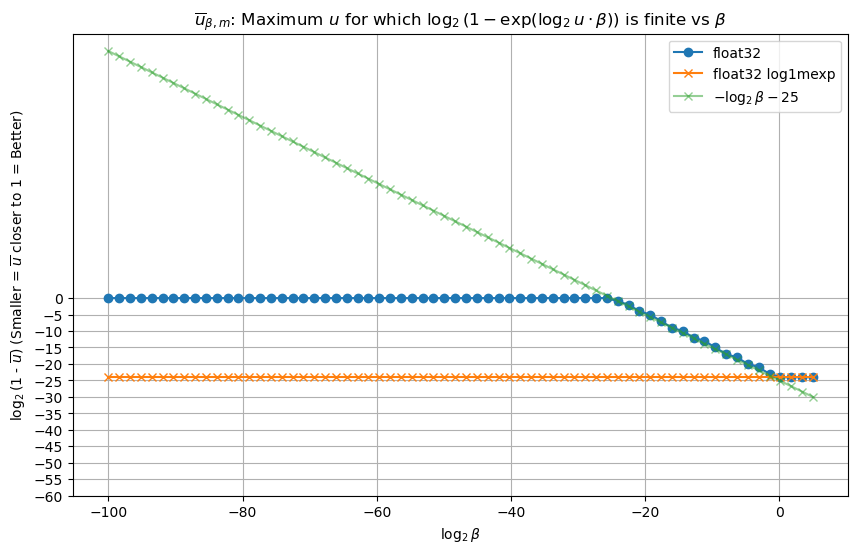

In [156]:
beta_exponents = torch.linspace(-100, 5, steps=66)
beta_values = torch.exp2(beta_exponents)

exp_values_32 = torch.arange(0, -150, -1, dtype=torch.float32)
u_values_32 = 1 - torch.exp2(exp_values_32)

exp_values_64 = torch.arange(0, -150, -1, dtype=torch.float64)
u_values_64 = 1 - torch.exp2(exp_values_64)

def get_vals(dtype):
    if dtype == torch.float32:
        return exp_values_32, u_values_32
    elif dtype == torch.float64:
        return exp_values_64, u_values_64
    else:
        raise ValueError("Invalid dtype.")

def find_failure_exponent(beta, dtype):
    # find the largest exponent m for which the computation stays finite
    exp_values, u_values = get_vals(dtype)
    #z = log2(1 - exp2(log2(u_values) * beta.to(dtype)))
    z = log(1-exp(log(u_values) * beta.to(dtype)))
    largest_exp_with_finite = exp_values[torch.isfinite(z)][-1]
    return largest_exp_with_finite

def find_failure_exponent_log1mexp(beta, dtype):
    exp_values, u_values = get_vals(dtype)
    z = log1mexp(-1 * log(u_values) * beta.to(dtype))
    t = torch.log2(beta.to(dtype) * (1 - u_values))
    largest_exp_with_finite = exp_values[torch.isfinite(z)][-1]
    return largest_exp_with_finite

failure_exponents_32 = [find_failure_exponent(beta, dtype=torch.float32) for beta in beta_values]
log1mexp_failure_exponents_32 = [find_failure_exponent_log1mexp(beta, dtype=torch.float32) for beta in beta_values]

# Plot the failure exponent vs beta
plt.figure(figsize=(10, 6))
plt.plot(beta_exponents, failure_exponents_32, marker='o', label='float32')
plt.plot(beta_exponents, log1mexp_failure_exponents_32, marker='x', label='float32 log1mexp')

# fitted line
plt.plot(beta_exponents, -beta_exponents - 25., marker='x', label=r'$-\log_2 \beta - 25$', alpha=0.5)
plt.xlabel(r'$\log_2 \beta$')
plt.ylabel(r'$\log_2$(1 - $\overline{u}$) (Smaller = $\overline{u}$ closer to 1 = Better)')
plt.title(r'$\overline{u}_{\beta, m}$: Maximum $u$ for which $\log_2(1-\exp(\log_2 u \cdot \beta))$ is finite vs $\beta$')

plt.legend()
plt.grid(True)
plt.yticks(np.arange(-60, 5, 5))
plt.show()